In [1]:
!unzip -q /content/models_predictions.zip -d /content/data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [3]:
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

In [4]:
csv_dir = '/content/data/models_predictions'

## Create the data

In [5]:
# Initialize a list to store the data with model information
data = []

# Loop over each CSV file in the directory
for filename in os.listdir(csv_dir):
    if filename.endswith(".csv"):
        model_name = filename.replace(".csv", "")

        # Drop models that didn't work
        if model_name in ["google_gemma-2-27b", "google_gemma-2-27b-it"]:
          continue
        # Load the CSV file
        file_path = os.path.join(csv_dir, filename)
        df = pd.read_csv(file_path)

        # handle too long model names
        if model_name == "nvidia_Llama-3.1-Nemotron-70B-Instruct-HF":
            model_name = "nvidia_Nemotron-70B-Instruct"

        # Add a 'model' column based on the filename
        df['model'] = '_'.join(model_name.split('_')[1:])

        # Append to the list
        data.append(df)

# Concatenate all data into a single DataFrame
all_data = pd.concat(data, ignore_index=True)
all_data['is_correct_prediction'] = all_data['correct_probability'] > all_data['incorrect_probability']
all_data = all_data.sort_values(
    by=['model', 'type'],
    key=lambda col: col.str.lower()
)



In [6]:
# All the types
all_data["type"].unique()

array(['first_center_com', 'first_center_mid', 'first_center_sim',
       'first_center_sim_rev', 'second_center_com', 'second_center_mid',
       'second_center_sim', 'second_center_sim_rev'], dtype=object)

In [7]:
all_data['center_type'] = all_data['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
all_data['wording'] = all_data['type'].apply( lambda x: 'com' if x.endswith('com') else
              ('mid' if x.endswith('mid') else
               ('sim' if x.endswith('sim') else
                ('sim_rev' if x.endswith('sim_rev') else 'non_com'))
              ))

In [8]:
with_sim_rev = all_data.copy()

In [9]:
all_data = all_data[~all_data["type"].isin(["first_center_sim_rev", "second_center_sim_rev"])]

In [10]:
all_data.sort_values(by=["set_id", "model"]).head(16)

,sentence,question,set_id,type,answer,correct_option,correct_first_token,correct_probability,incorrect_option,incorrect_first_token,incorrect_probability,predicted_answer,is_correct_prediction,model,center_type,wording
5265,The child that the neighbor that the guest scared liked fell.,Who did the neighbor like?,1,first_center_com,The child,child,3124,0.511717,guest,31277,0.488283,Thechildguestchildguest,True,Llama-3.1-70B-Instruct,first_center,com
5267,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the neighbor like?,1,first_center_mid,The child,child,3124,0.953622,guest,31277,0.046378,Thechildchildchildchild,True,Llama-3.1-70B-Instruct,first_center,mid
5269,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the neighbor like?,1,first_center_sim,The child,child,3124,0.959154,guest,31277,0.040846,Thechildchildchildchild,True,Llama-3.1-70B-Instruct,first_center,sim
5264,The child that the neighbor that the guest scared liked fell.,Who did the guest scare?,1,second_center_com,The neighbor,neighbor,37569,0.258326,child,3124,0.741674,Thechildneighborneighborneighbor,False,Llama-3.1-70B-Instruct,second_center,com
5266,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the guest scare?,1,second_center_mid,The neighbor,neighbor,37569,0.307358,child,3124,0.692642,Thechildneighborneighborchild,False,Llama-3.1-70B-Instruct,second_center,mid
5268,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the guest scare?,1,second_center_sim,The neighbor,neighbor,37569,0.846958,child,3124,0.153042,Theneighborneighborneighborneighbor,True,Llama-3.1-70B-Instruct,second_center,sim
2633,The child that the neighbor that the guest scared liked fell.,Who did the neighbor like?,1,first_center_com,The child,child,3124,0.384912,guest,31277,0.615088,Theguestchildchildchild,False,Llama-3.1-8B,first_center,com
2635,"The child, who was liked by the neighbor scared by the guest, fell.",Who did the neighbor like?,1,first_center_mid,The child,child,3124,0.626124,guest,31277,0.373876,Thechildchildchildchild,True,Llama-3.1-8B,first_center,mid
2637,"There is that neighbor scared by the guest, so the child, who was liked by the neighbor, fell.",Who did the neighbor like?,1,first_center_sim,The child,child,3124,0.875787,guest,31277,0.124213,Thechildguestchildguest,True,Llama-3.1-8B,first_center,sim
2632,The child that the neighbor that the guest scared liked fell.,Who did the guest scare?,1,second_center_com,The neighbor,neighbor,37569,0.501953,child,3124,0.498047,Theneighborchildneighborchild,True,Llama-3.1-8B,second_center,com


In [11]:
def create_groupby(df):
  accuracy_by_model_and_type = (
      df
      .groupby(['model', 'type'])['is_correct_prediction']
      .mean()
      .reset_index()
      .rename(columns={'is_correct_prediction': 'accuracy'})
  )
  # Case-insensitive sorting by multiple columns (e.g., 'model' and 'type')
  accuracy_by_model_and_type = accuracy_by_model_and_type.sort_values(
      by=['model', 'type'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)


  # Extract center type and suffix from the `type` column
  accuracy_by_model_and_type['center_type'] = accuracy_by_model_and_type['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
  accuracy_by_model_and_type['wording'] = accuracy_by_model_and_type['type'].apply(
      lambda x: 'com' if x.endswith('com') else
                ('mid' if x.endswith('mid') else
                ('sim' if x.endswith('sim') else
                  ('sim_rev' if x.endswith('sim_rev') else 'non_com')))
  )
  return accuracy_by_model_and_type

accuracy_by_model_and_type = create_groupby(all_data)
accuracy_by_model_and_type_with_sim_rev = create_groupby(with_sim_rev)


In [12]:
accuracy_by_model_and_type.head()

,model,type,accuracy,center_type,wording
0,gemma-2-2b,first_center_com,0.914894,first_center,com
1,gemma-2-2b,first_center_mid,0.872340,first_center,mid
2,gemma-2-2b,first_center_sim,0.914894,first_center,sim
3,gemma-2-2b,second_center_com,0.191489,second_center,com
4,gemma-2-2b,second_center_mid,0.468085,second_center,mid


In [13]:
res_dir = "/content/res"
if not os.path.exists(res_dir):
    os.makedirs(res_dir)

## General

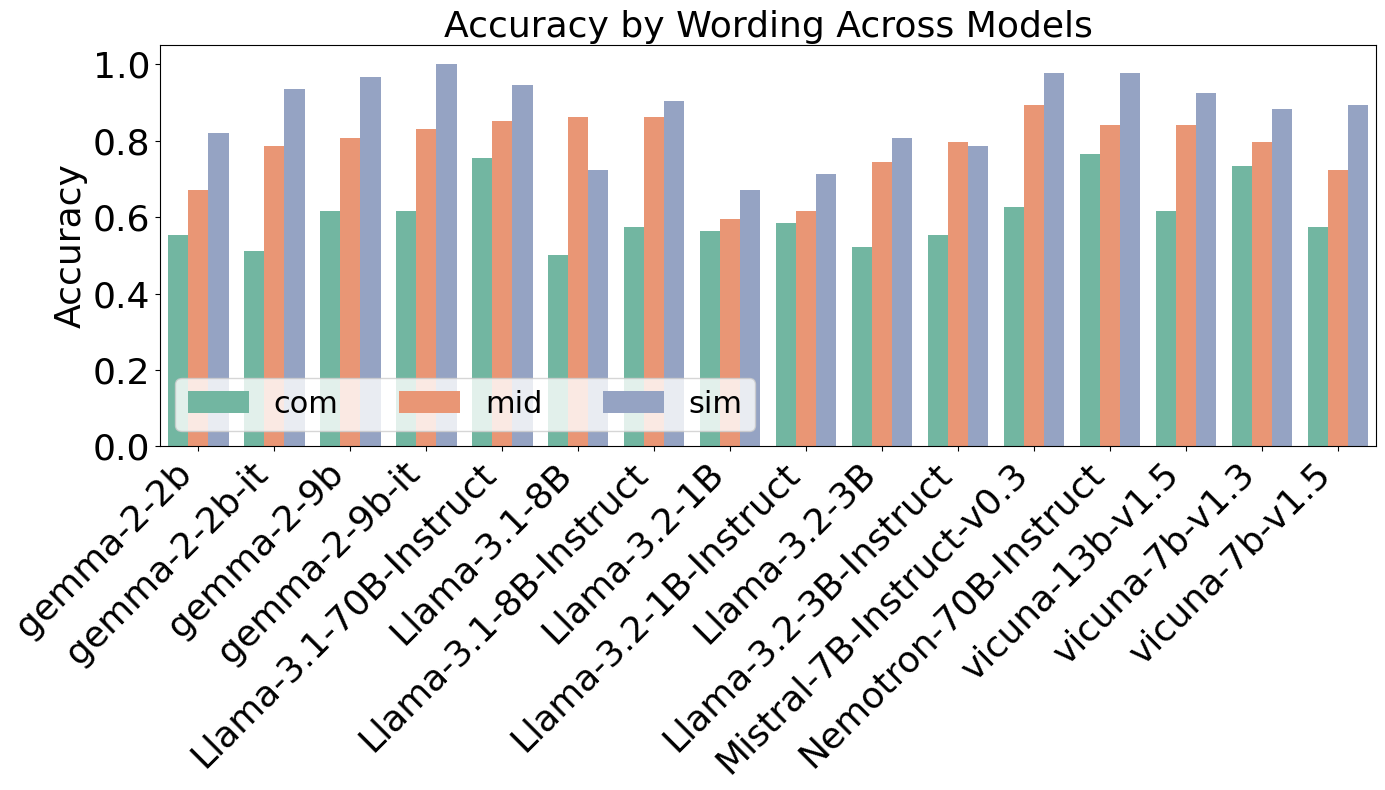

In [14]:
# Extract center type and suffix from the `type` column
#accuracy_by_model_and_type['center_type'] = accuracy_by_model_and_type['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
#accuracy_by_model_and_type['suffix'] = accuracy_by_model_and_type['type'].apply(lambda x: '_'.join(x.split('_')[2:]))

# Calculate the average accuracy for each model, center type, and suffix
avg_accuracy = accuracy_by_model_and_type.groupby(['model', 'wording'])['accuracy'].mean().reset_index()
avg_accuracy = avg_accuracy.sort_values(
    by=['model', 'wording'],
    key=lambda col: col.str.lower(),
).reset_index(drop=True)

# Set up the figure
plt.figure(figsize=(14, 8))

# Create the bar plot
sns.barplot(
    data=avg_accuracy,
    x='model',
    y='accuracy',
    hue='wording',  # Combining center type and suffix for color coding
    palette='Set2'
)

# Customize the plot
title = 'Accuracy by Wording Across Models'
plt.title(title, fontsize='26')
plt.xlabel('')
plt.ylabel('Accuracy', fontsize='26')
plt.legend(loc='lower left', fontsize='22', ncol=3)
plt.xticks(rotation=45, ha='right', fontsize=26)
plt.yticks(fontsize=26)

# Save figure
filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
file_path = os.path.join(res_dir, filename)
plt.savefig(file_path)


# Show plot
plt.tight_layout()
plt.show()

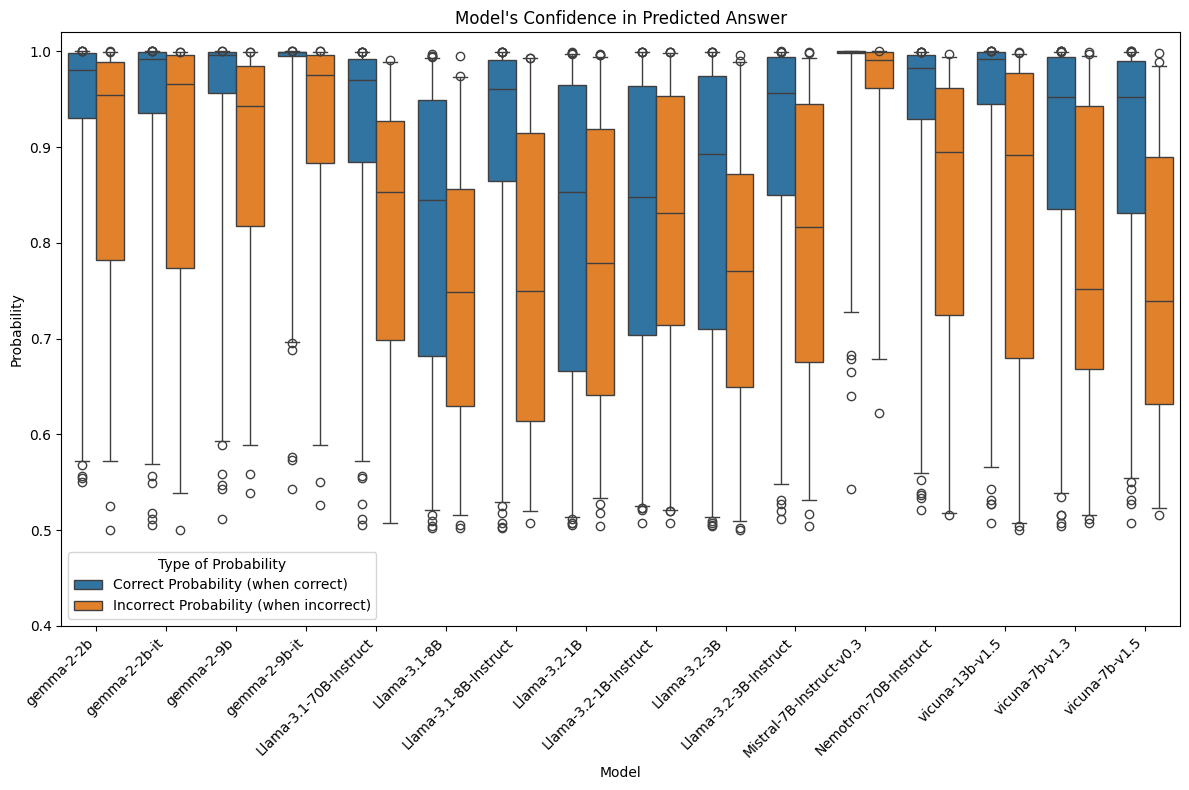

In [15]:
# Filter data for correct and incorrect predictions
correct_data = all_data[all_data['is_correct_prediction'] == True][['model', 'correct_probability']]
incorrect_data = all_data[all_data['is_correct_prediction'] == False][['model', 'incorrect_probability']]

# Rename columns for consistency in plotting
correct_data = correct_data.rename(columns={'correct_probability': 'probability'})
incorrect_data = incorrect_data.rename(columns={'incorrect_probability': 'probability'})

# Add a column indicating the type of probability
correct_data['type'] = 'Correct Probability (when correct)'
incorrect_data['type'] = 'Incorrect Probability (when incorrect)'

# Combine the two datasets
plot_data = pd.concat([correct_data, incorrect_data], ignore_index=True)
plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a boxplot
sns.boxplot(
    data=plot_data,
    x='model',
    y='probability',
    hue='type',
    dodge=True,
    whis=[2,98]
)
plt.title('Model\'s Confidence in Predicted Answer')
plt.xlabel('Model')
plt.ylabel('Probability')
plt.legend(title='Type of Probability')
plt.ylim(0.4,1.02)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [16]:
plot_data.head()

,model,probability,type
0,gemma-2-2b,0.837620,Correct Probability (when correct)
1,gemma-2-2b,0.916708,Correct Probability (when correct)
2,gemma-2-2b,0.991084,Correct Probability (when correct)
3,gemma-2-2b,0.930458,Correct Probability (when correct)
4,gemma-2-2b,0.554470,Correct Probability (when correct)


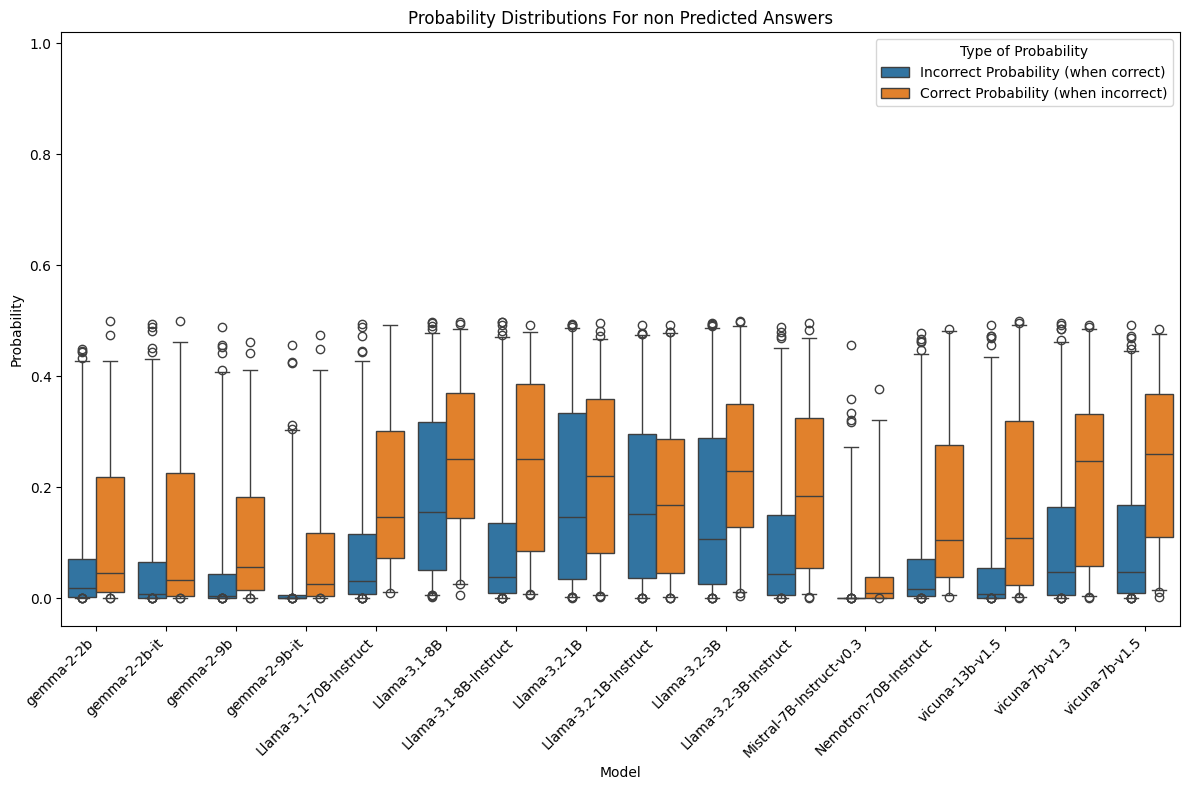

In [17]:
# Filter data for correct and incorrect predictions
correct_data = all_data[all_data['is_correct_prediction'] == True][['model', 'incorrect_probability']]
incorrect_data = all_data[all_data['is_correct_prediction'] == False][['model', 'correct_probability']]

# Rename columns for consistency in plotting
correct_data = correct_data.rename(columns={'incorrect_probability': 'probability'})
incorrect_data = incorrect_data.rename(columns={'correct_probability': 'probability'})

# Add a column indicating the type of probability
correct_data['type'] = 'Incorrect Probability (when correct)'
incorrect_data['type'] = 'Correct Probability (when incorrect)'

# Combine the two datasets
plot_data = pd.concat([correct_data, incorrect_data], ignore_index=True)
plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Create a boxplot
sns.boxplot(
    data=plot_data,
    x='model',
    y='probability',
    hue='type',
    dodge=True,
    whis=[2,98]
)
plt.title('Probability Distributions For non Predicted Answers')
plt.xlabel('Model')
plt.ylabel('Probability')
plt.legend(title='Type of Probability')
plt.ylim(-0.05,1.02)
plt.xticks(rotation=45, ha='right', fontsize=10)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Com vs Non-Com

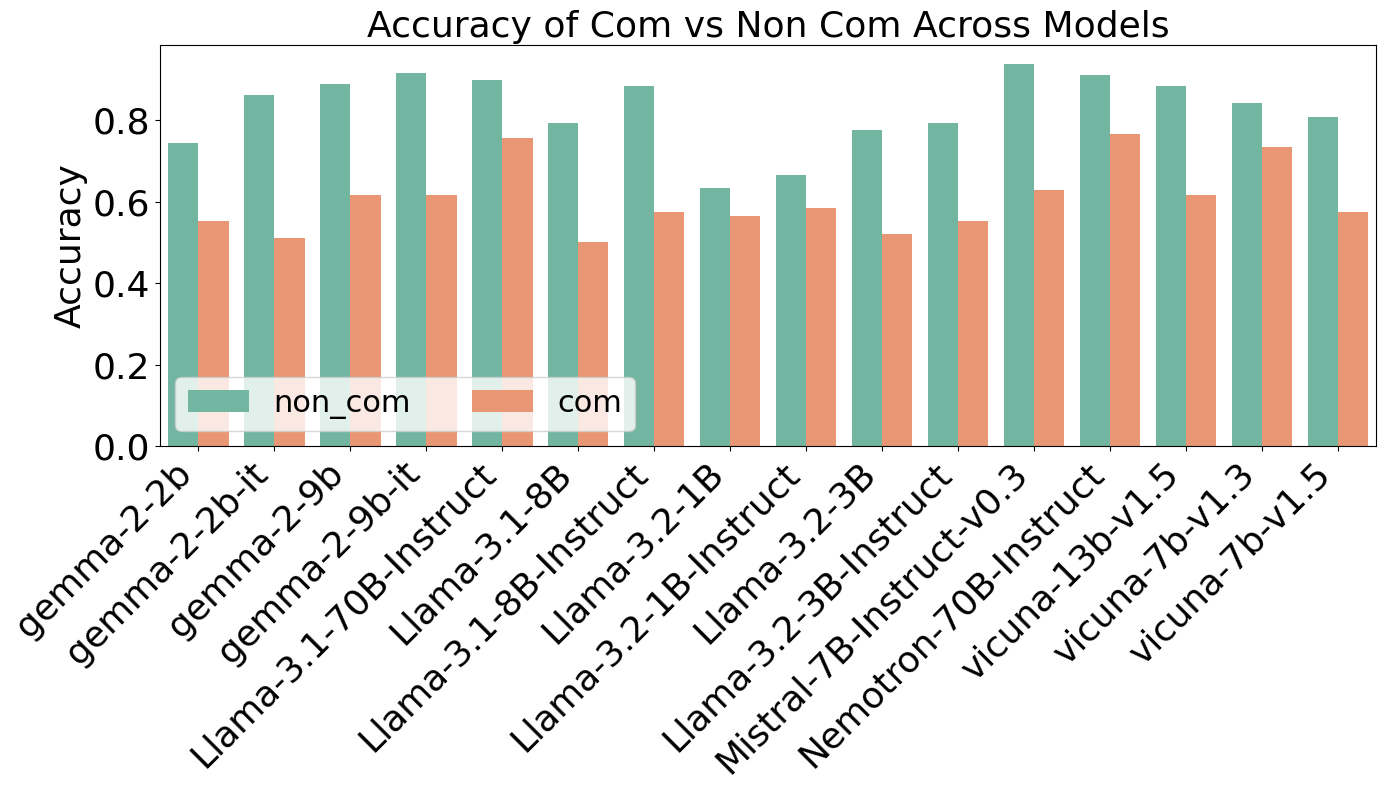

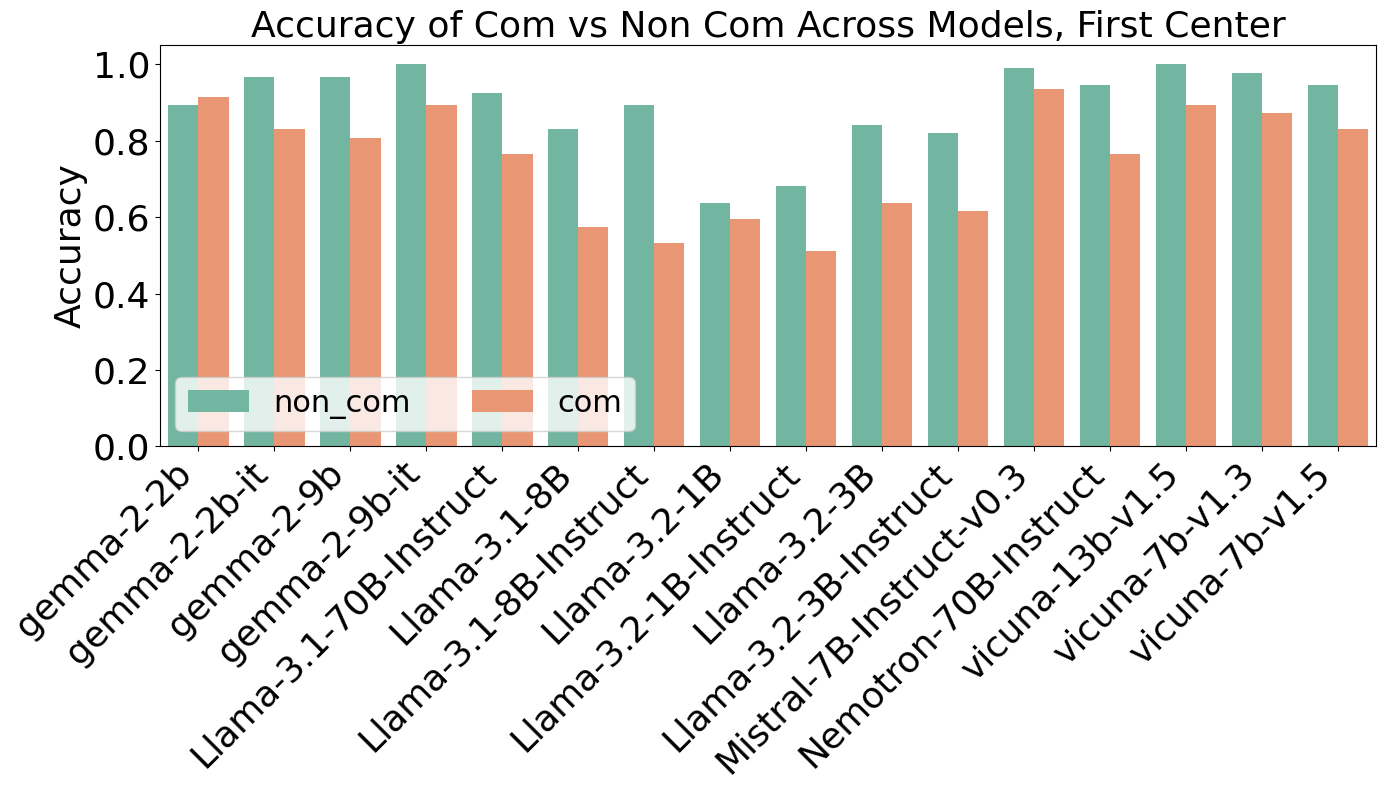

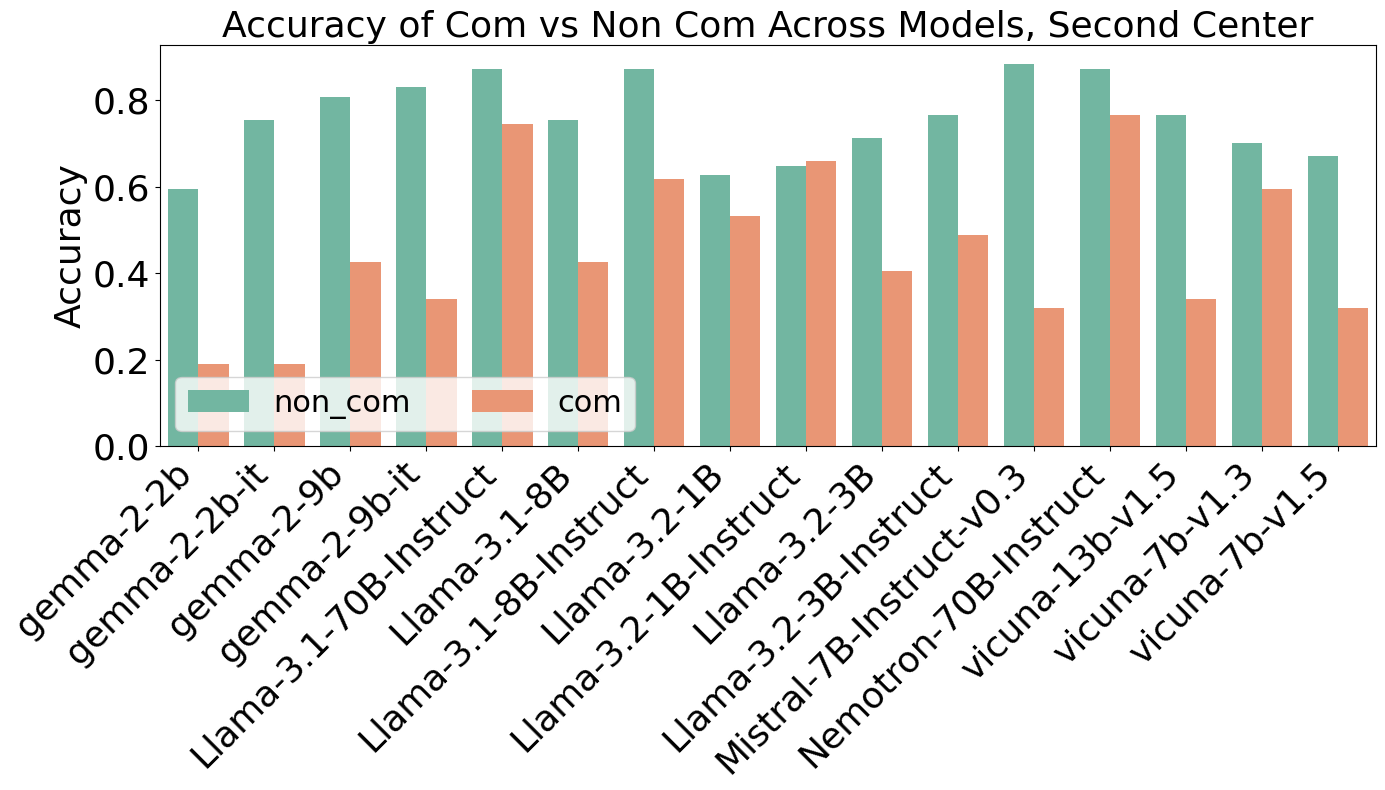

In [18]:
# Draw accuracy separated by center

# Extract center type and suffix from the `type` column
accuracy_by_model_and_type['center_type'] = accuracy_by_model_and_type['type'].apply(lambda x: 'first_center' if x.startswith('first_center') else 'second_center')
accuracy_by_model_and_type['wording_com'] = accuracy_by_model_and_type['type'].apply(lambda x: 'com' if 'com' in x else 'non_com')

def plot_accuracy_per_model(grouped_df, title):

  # Calculate the average accuracy for each model, center type, and suffix
  avg_accuracy = grouped_df.groupby(['model', 'wording_com'])['accuracy'].mean().reset_index()
  avg_accuracy = avg_accuracy.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the figure
  plt.figure(figsize=(14, 8))

  # Create the bar plot
  sns.barplot(
      data=avg_accuracy,
      x='model',
      y='accuracy',
      hue='wording_com',  # Combining center type and wording for color coding
      palette='Set2'
  )

  # Customize the plot
  plt.title(title, fontsize=26)
  plt.xlabel('')
  plt.ylabel('Accuracy', fontsize=26)
  plt.legend(loc='lower left', fontsize=22, ncols=2)
  plt.xticks(rotation=45, ha='right', fontsize=26)
  plt.yticks(fontsize=26)

  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)

  # Show plot
  plt.tight_layout()
  plt.show()

plot_accuracy_per_model(accuracy_by_model_and_type, 'Accuracy of Com vs Non Com Across Models')
first_center = accuracy_by_model_and_type[accuracy_by_model_and_type['center_type'] == "first_center"]
second_center = accuracy_by_model_and_type[accuracy_by_model_and_type['center_type'] == "second_center"]
plot_accuracy_per_model(first_center, title='Accuracy of Com vs Non Com Across Models, First Center')
plot_accuracy_per_model(second_center, title='Accuracy of Com vs Non Com Across Models, Second Center')

In [19]:
def confidence_com_non_com(all_data, isRight, filter= None):
  title_end=" (Com vs Non Com)"
  if filter== "first":
    all_data=all_data[all_data['center_type'] == 'first_center']
    title_end= " First Center"
  elif filter== "second":
     all_data=all_data[all_data['center_type'] == 'second_center']
     title_end= " Second Center"
  # Filter data for correct and incorrect predictions
  prob = 'correct_probability' if isRight else 'incorrect_probability'
  com_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['wording'] == 'com')][['model', prob]]
  non_com_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['wording'].isin(['sim', 'mid']))][['model', prob]]

  # Rename columns for consistency in plotting
  com_data = com_data.rename(columns={prob: 'probability'})
  non_com_data = non_com_data.rename(columns={prob: 'probability'})

  # Add a column indicating the type of probability
  com_data['type'] = 'Com'
  non_com_data['type'] = 'Non Com'

  # Combine the two datasets
  plot_data = pd.concat([com_data, non_com_data], ignore_index=True)
  plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the matplotlib figure
  plt.figure(figsize=(12, 8))

  # Create a boxplot
  sns.boxplot(
      data=plot_data,
      x='model',
      y='probability',
      hue='type',
      dodge=True,
      whis=[2,98]
  )
  is_right_title= "Right" if isRight else "Wrong"
  title= 'Confidence - Probability Distributions ' + is_right_title + title_end
  plt.title(title)
  plt.xlabel('Model')
  plt.ylabel('Probability')
  plt.legend(title='Type of Probability')
  plt.ylim(-0.05,1.02)
  plt.xticks(rotation=45, ha='right', fontsize=10)


  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)


  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()



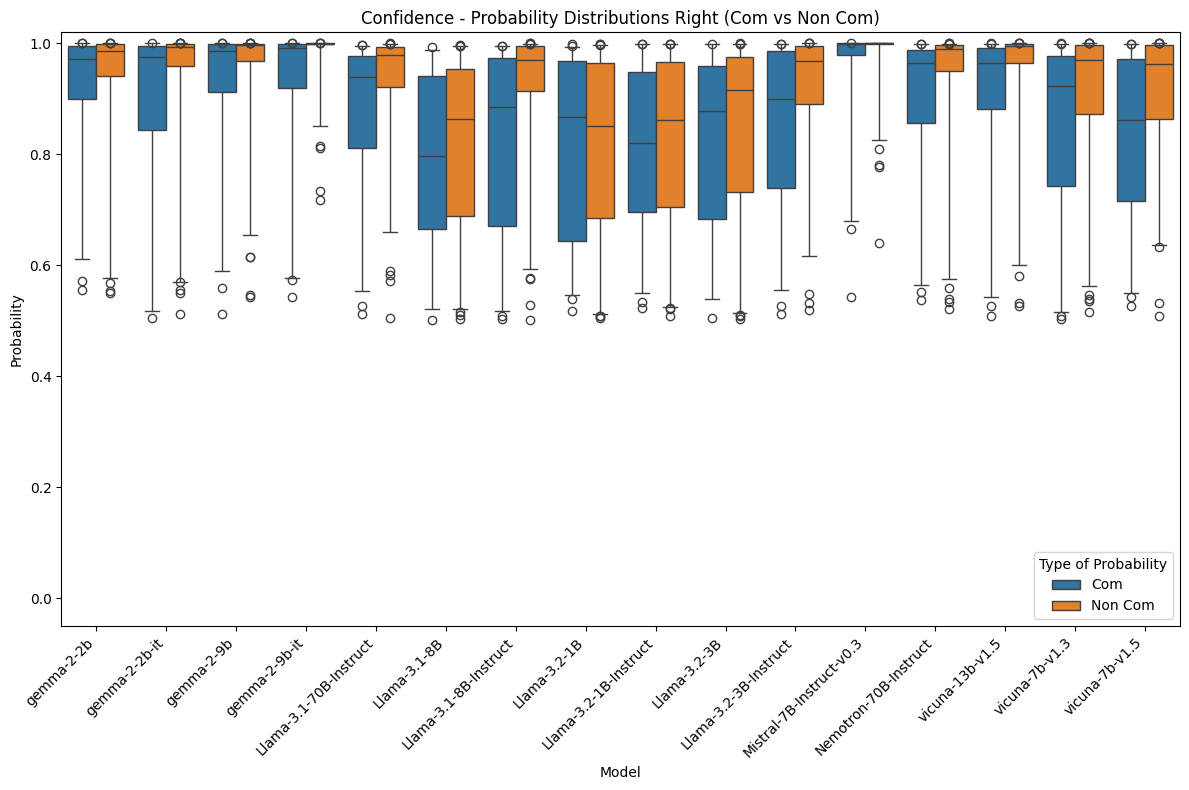

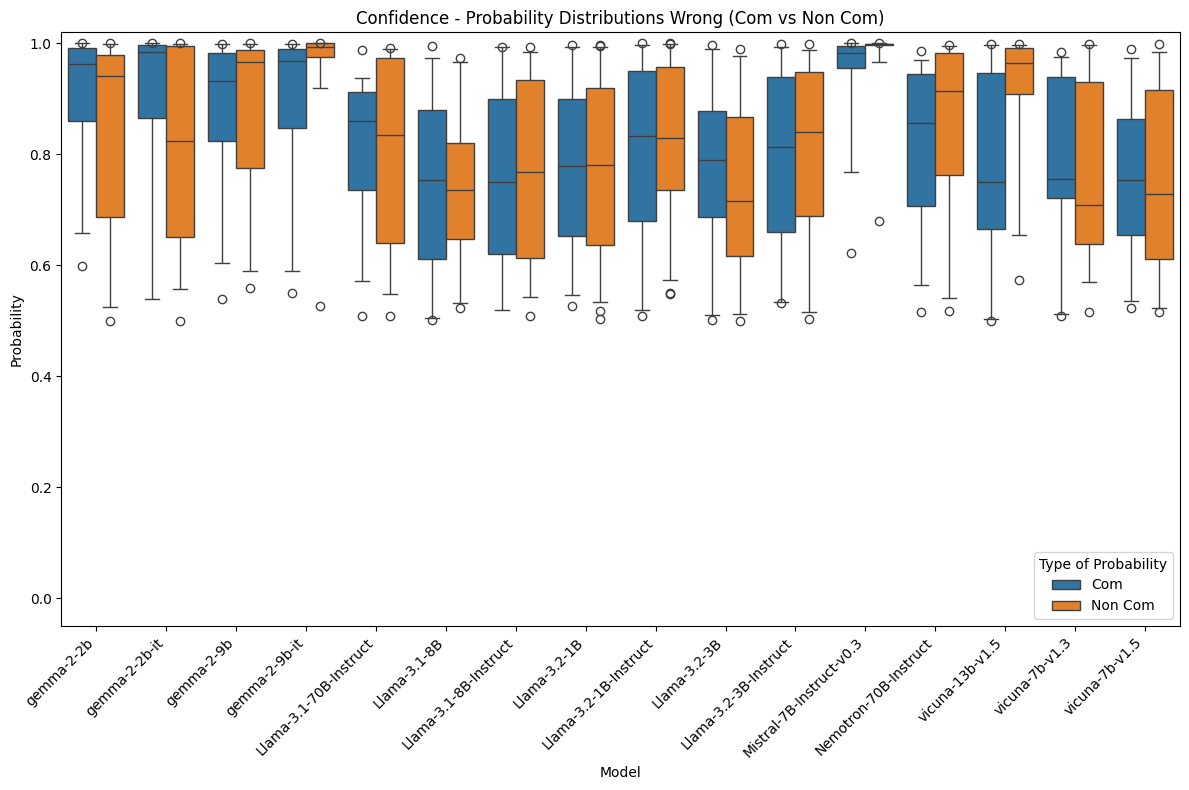

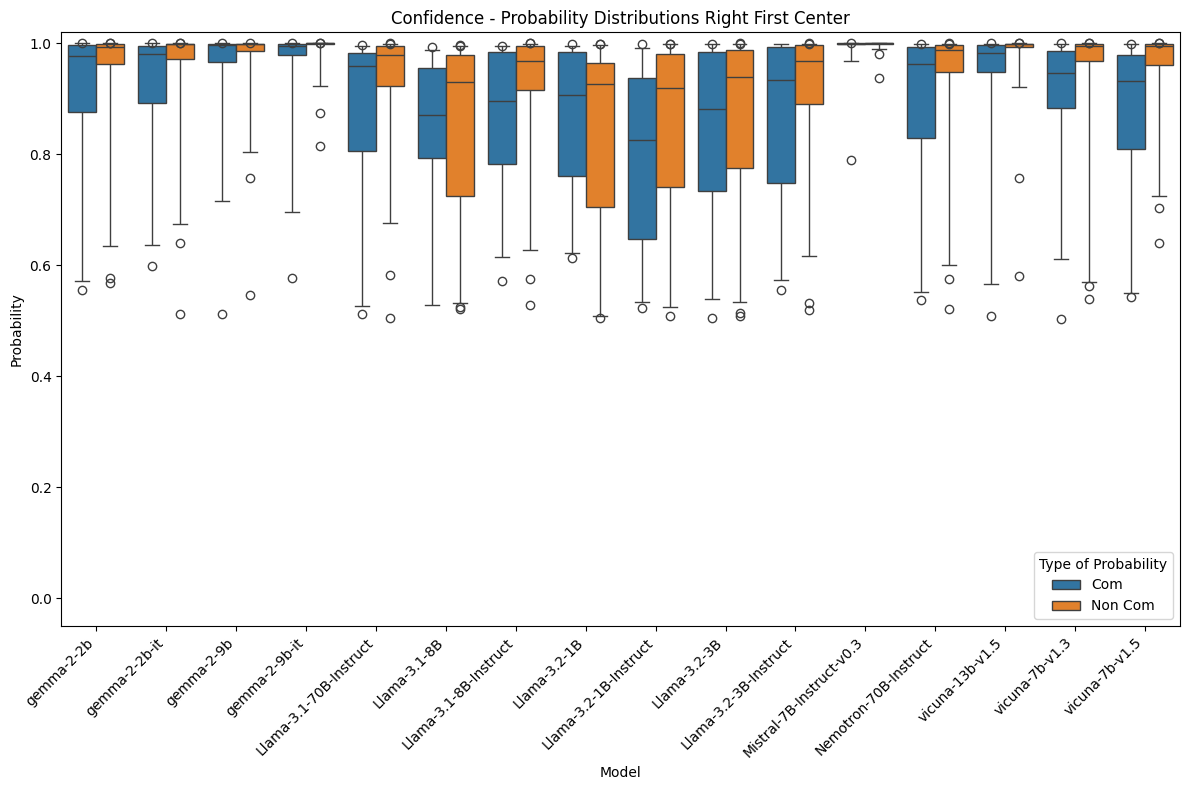

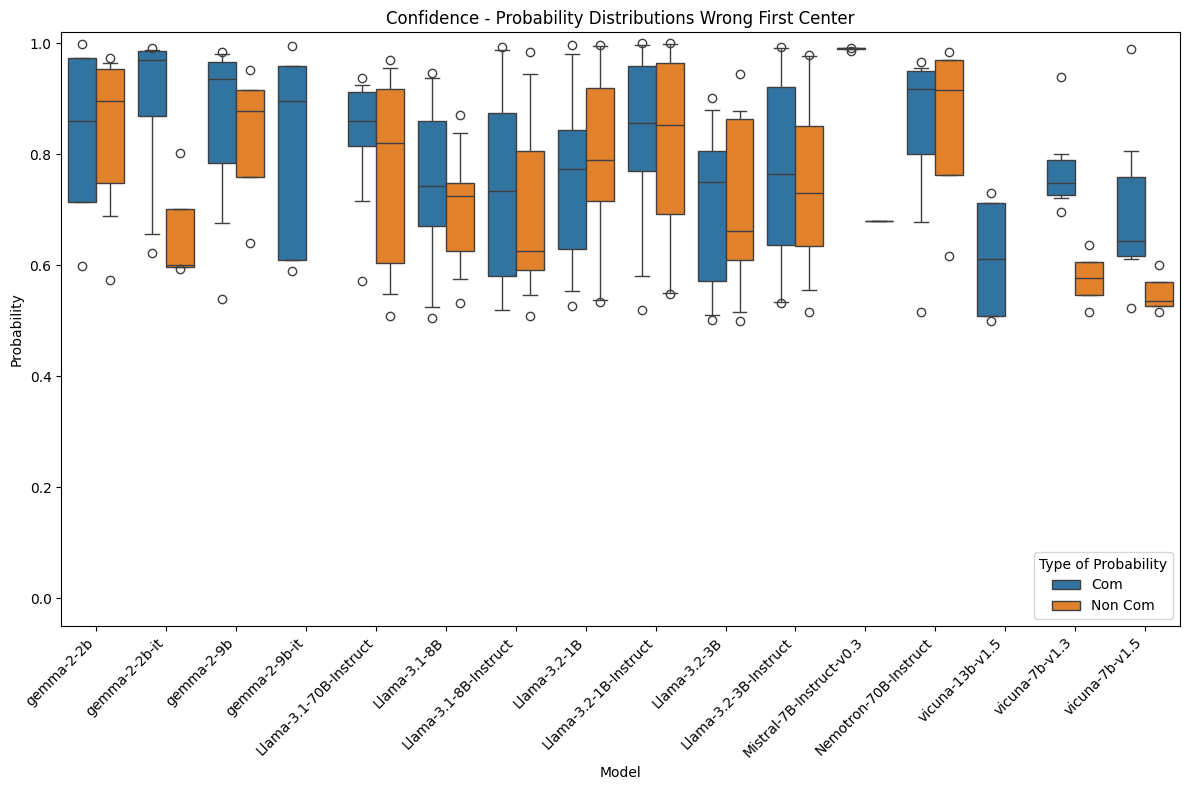

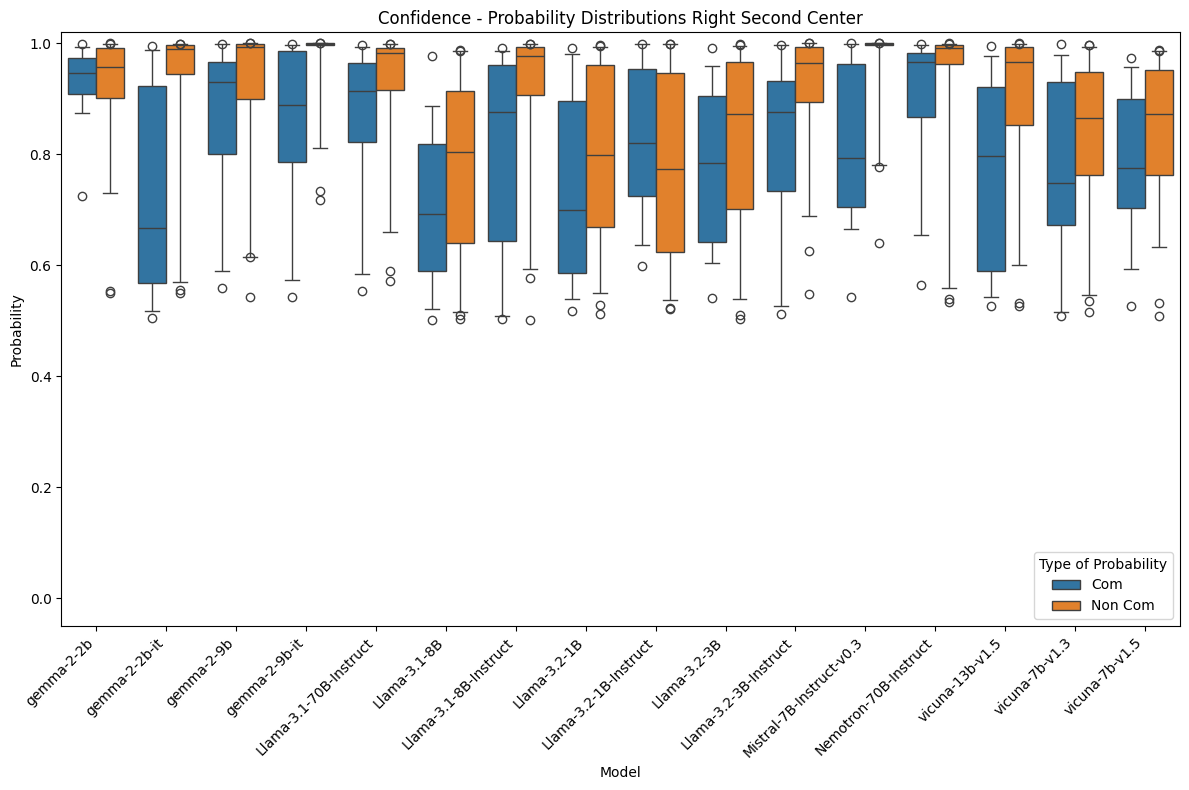

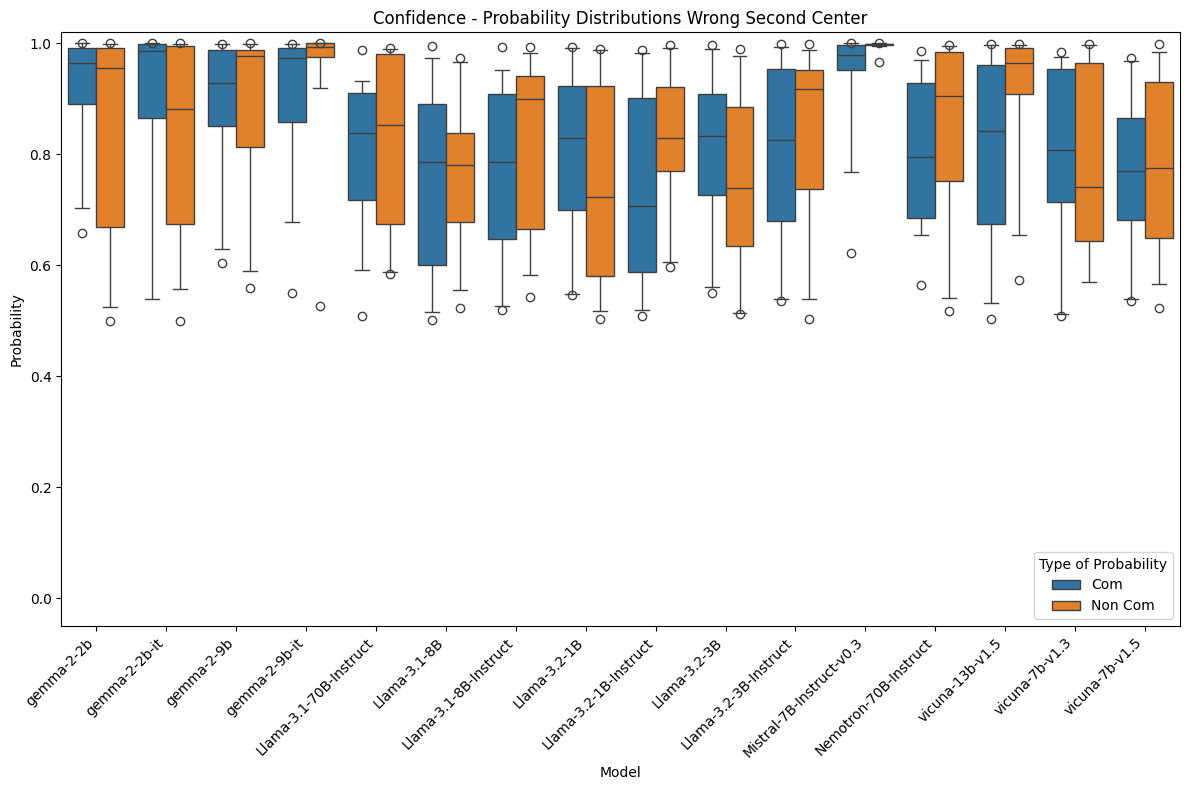

In [20]:

confidence_com_non_com(all_data=all_data,isRight=True)
confidence_com_non_com(all_data=all_data,isRight=False)
confidence_com_non_com(all_data=all_data, isRight=True,filter= "first")
confidence_com_non_com(all_data=all_data, isRight=False, filter="first")
confidence_com_non_com(all_data=all_data, isRight=True, filter="second")
confidence_com_non_com(all_data=all_data, isRight=False, filter="second")



## First Center vs Second Center

In [21]:
accuracy_by_model_and_type.head()

,model,type,accuracy,center_type,wording,wording_com
0,gemma-2-2b,first_center_com,0.914894,first_center,com,com
1,gemma-2-2b,first_center_mid,0.872340,first_center,mid,non_com
2,gemma-2-2b,first_center_sim,0.914894,first_center,sim,non_com
3,gemma-2-2b,second_center_com,0.191489,second_center,com,com
4,gemma-2-2b,second_center_mid,0.468085,second_center,mid,non_com


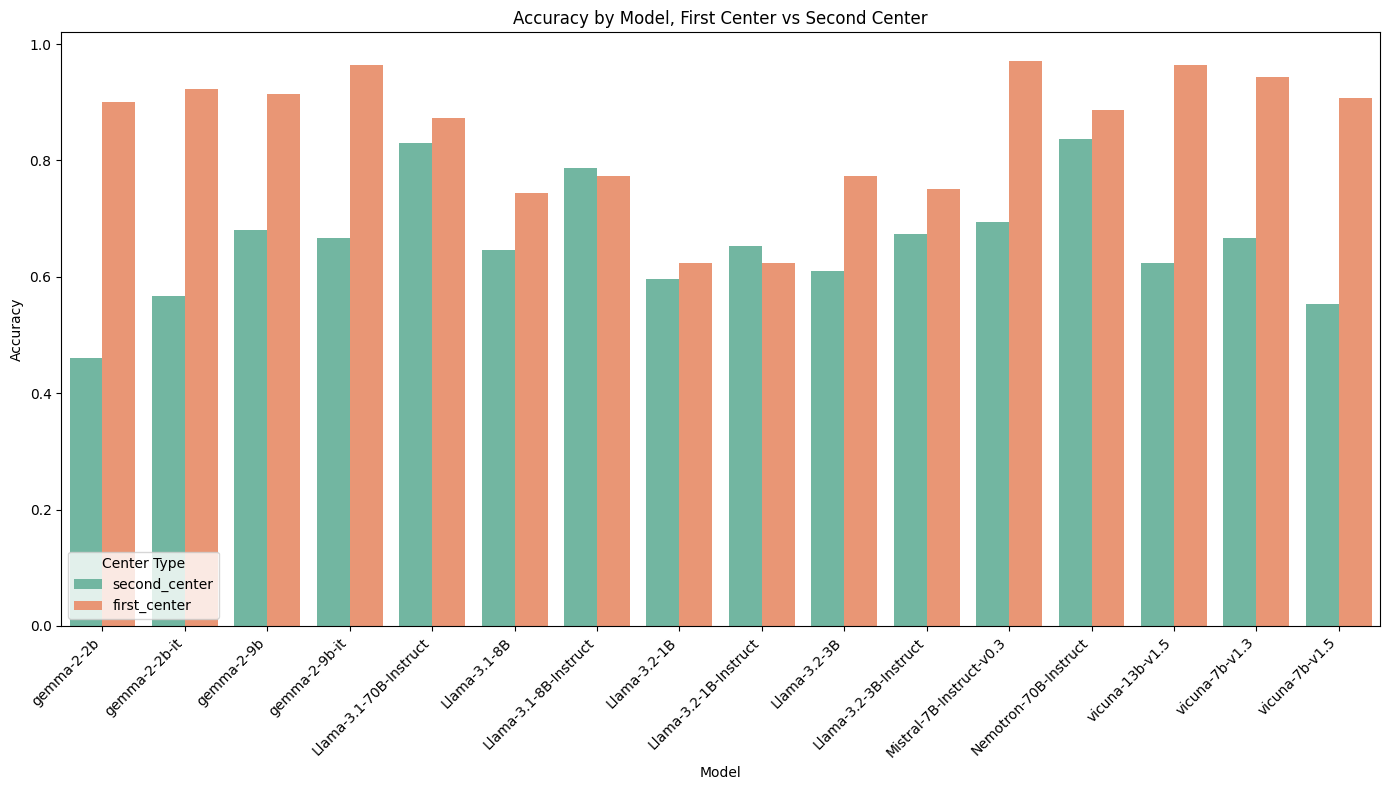

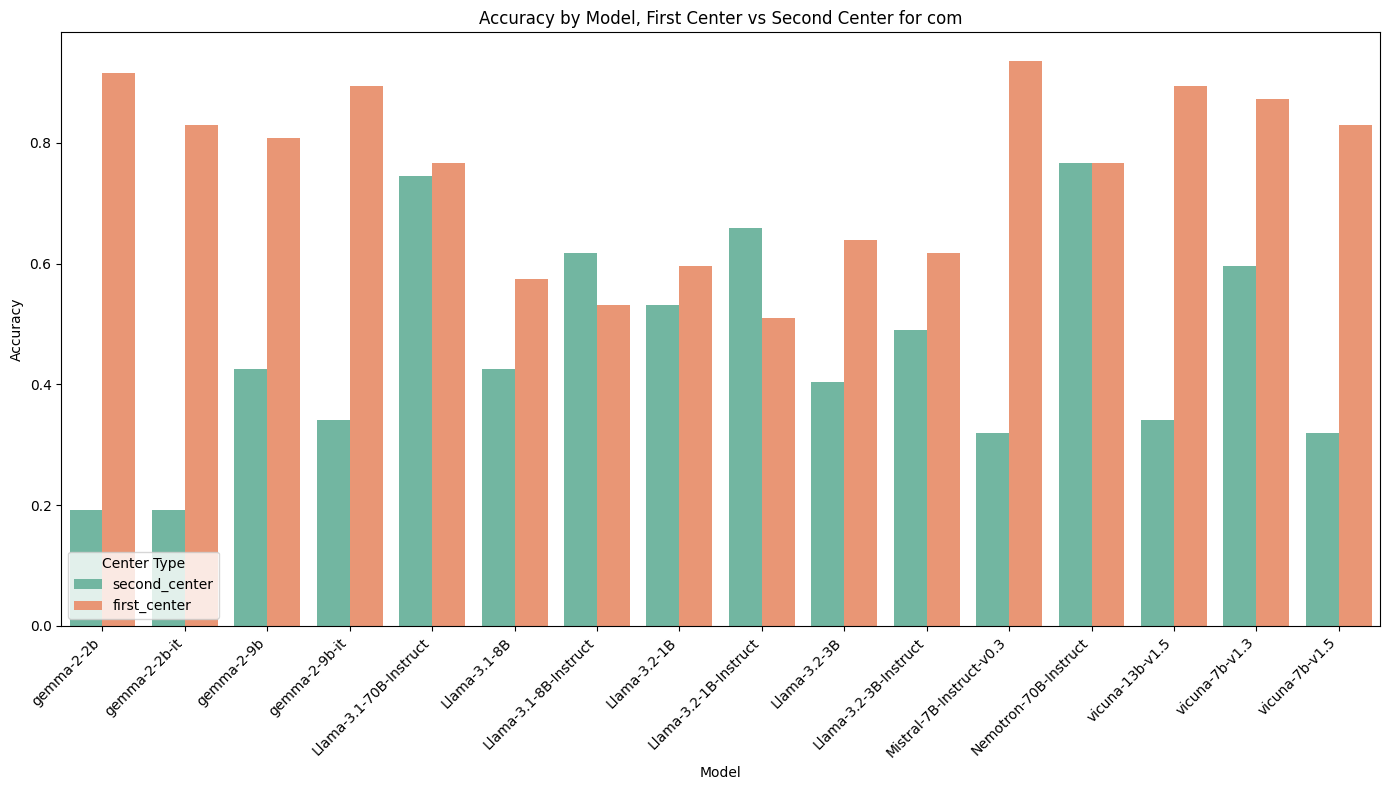

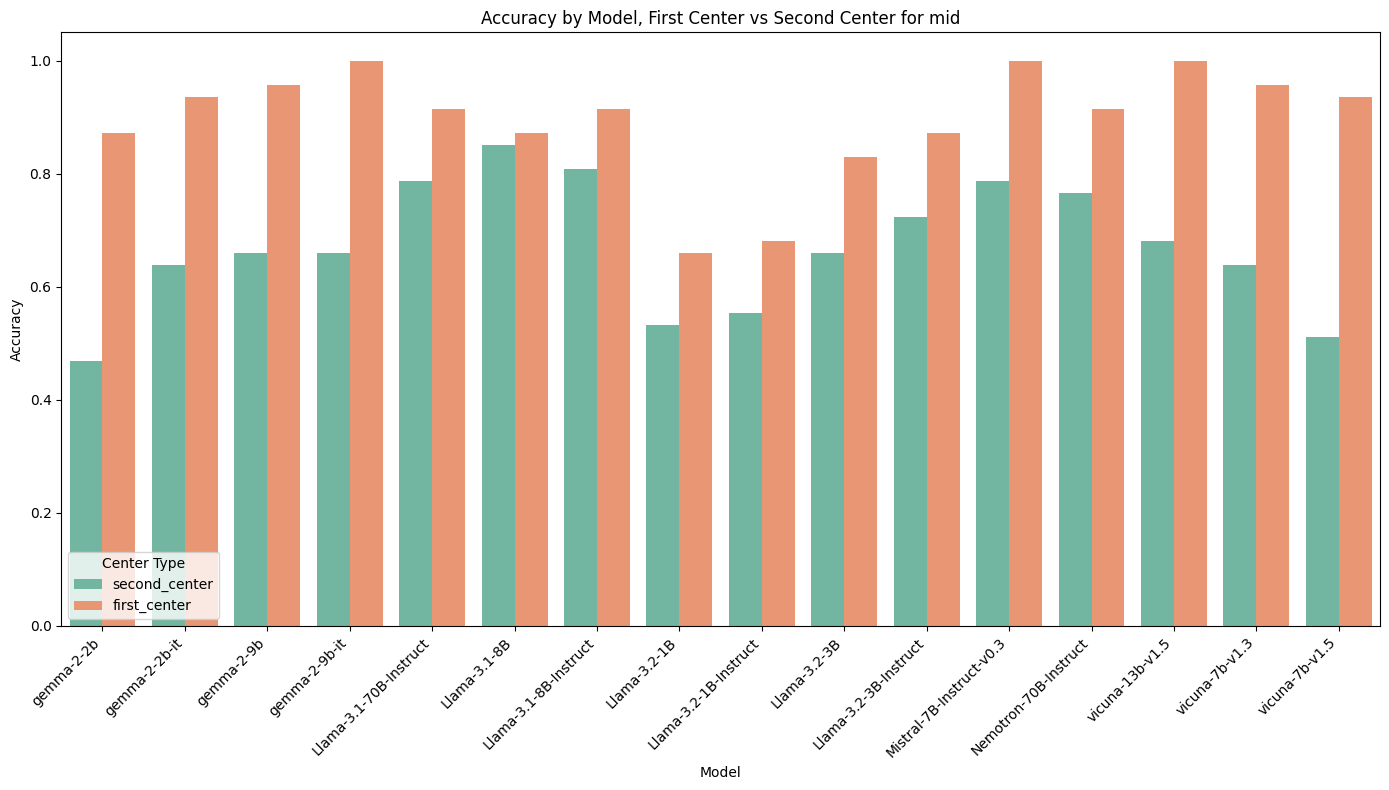

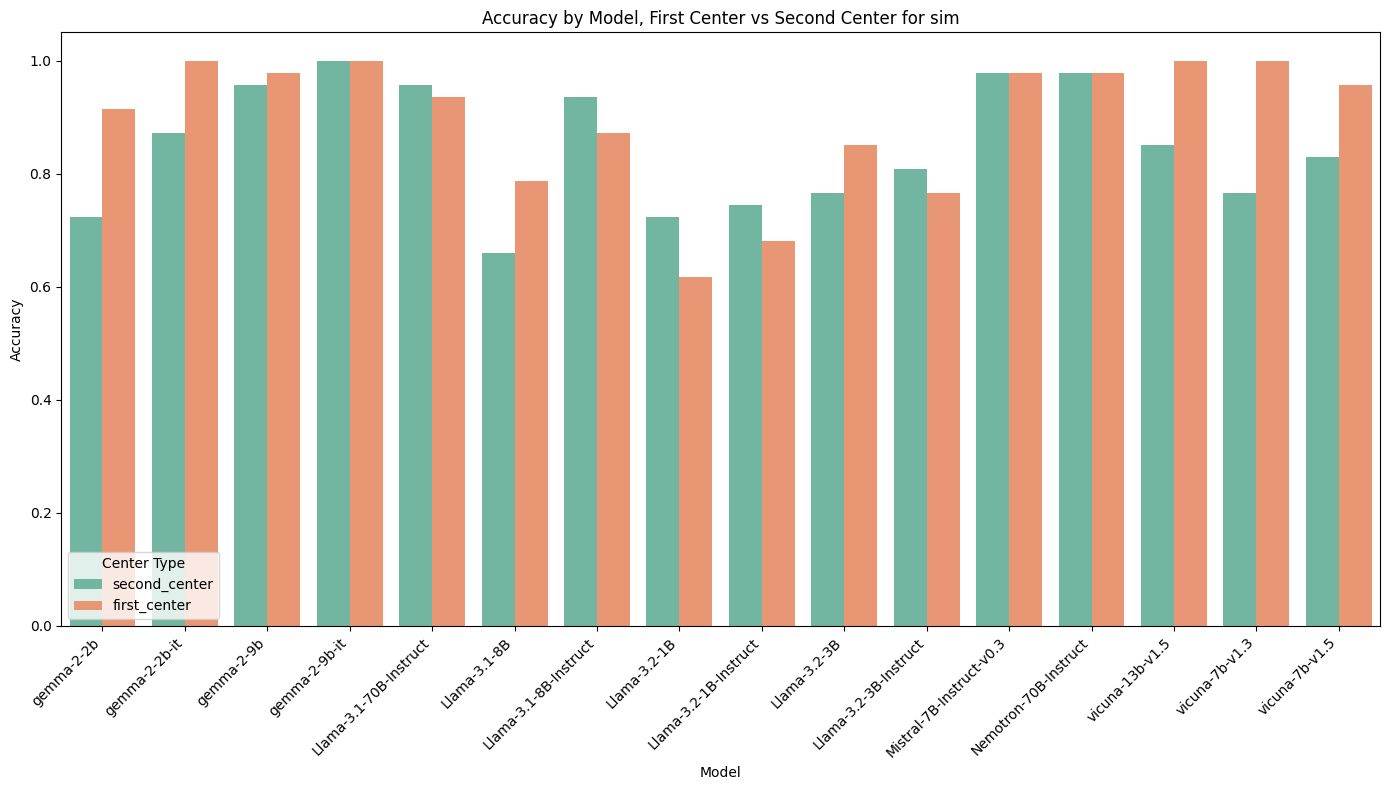

In [22]:
# Draw accuracy separated by center


def plot_accuracy_per_model(grouped_df, title):

  # Calculate the average accuracy for each model, center type, and suffix
  avg_accuracy = grouped_df.groupby(['model', 'center_type'])['accuracy'].mean().reset_index()
  avg_accuracy = avg_accuracy.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the figure
  plt.figure(figsize=(14, 8))

  # Create the bar plot
  sns.barplot(
      data=avg_accuracy,
      x='model',
      y='accuracy',
      hue='center_type',  # Combining center type and wording for color coding
      palette='Set2'
  )

  # Customize the plot
  plt.title(title)
  plt.xlabel('Model')
  plt.ylabel('Accuracy')
  plt.legend(title='Center Type', loc='lower left')
  plt.xticks(rotation=45, ha='right', fontsize=10)

  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)

  # Show plot
  plt.tight_layout()
  plt.show()

plot_accuracy_per_model(accuracy_by_model_and_type, 'Accuracy by Model, First Center vs Second Center')
com = accuracy_by_model_and_type[accuracy_by_model_and_type['wording'] == "com"]
mid = accuracy_by_model_and_type[accuracy_by_model_and_type['wording'] == "mid"]
sim = accuracy_by_model_and_type[accuracy_by_model_and_type['wording'] == "sim"]

plot_accuracy_per_model(com, title='Accuracy by Model, First Center vs Second Center for com')
plot_accuracy_per_model(mid, title='Accuracy by Model, First Center vs Second Center for mid')
plot_accuracy_per_model(sim, title='Accuracy by Model, First Center vs Second Center for sim')

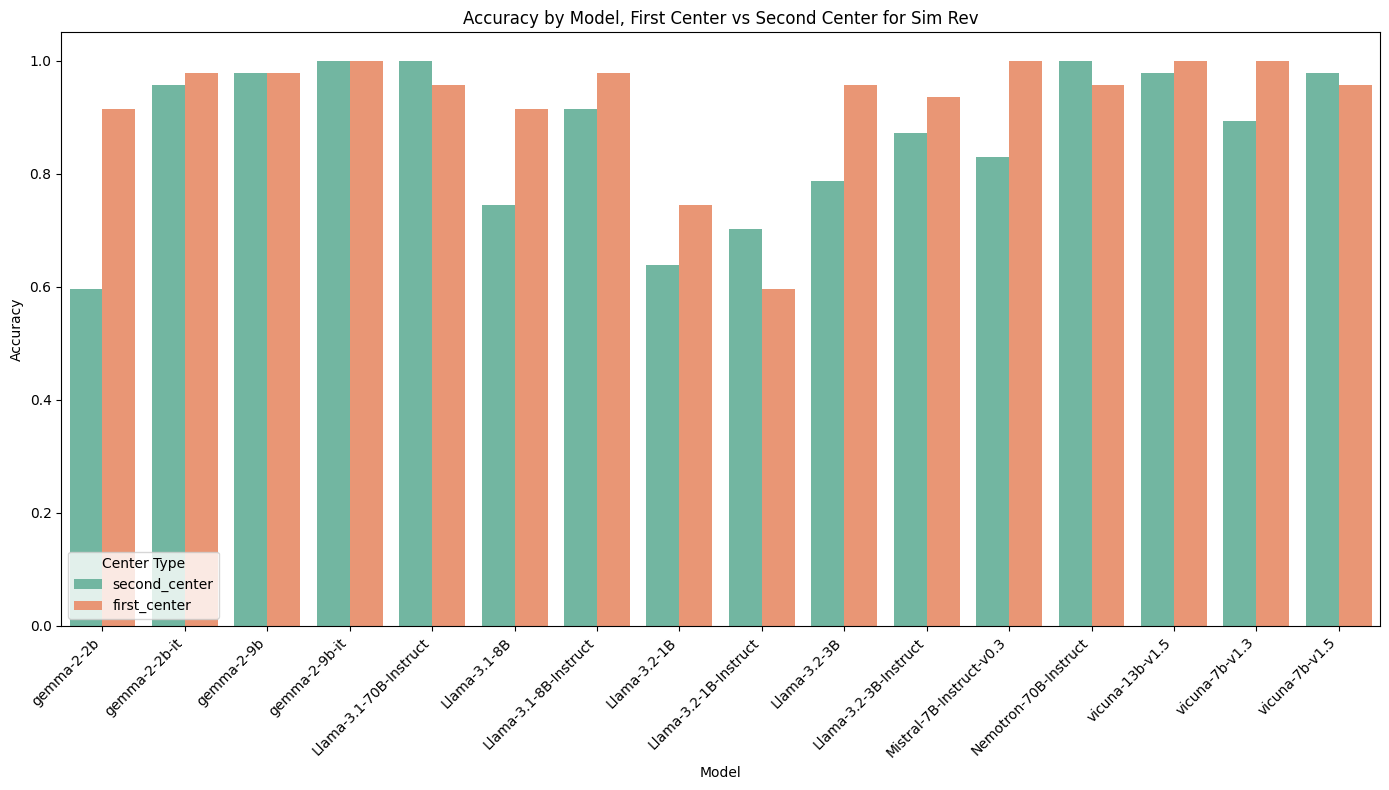

In [23]:
# Plot for sim rev
sim_rev = accuracy_by_model_and_type_with_sim_rev[accuracy_by_model_and_type_with_sim_rev['wording'] == "sim_rev"]
plot_accuracy_per_model(sim_rev, title='Accuracy by Model, First Center vs Second Center for Sim Rev')


In [24]:
sim_rev

,model,type,accuracy,center_type,wording
3,gemma-2-2b,first_center_sim_rev,0.914894,first_center,sim_rev
7,gemma-2-2b,second_center_sim_rev,0.595745,second_center,sim_rev
11,gemma-2-2b-it,first_center_sim_rev,0.978723,first_center,sim_rev
15,gemma-2-2b-it,second_center_sim_rev,0.957447,second_center,sim_rev
19,gemma-2-9b,first_center_sim_rev,0.978723,first_center,sim_rev
23,gemma-2-9b,second_center_sim_rev,0.978723,second_center,sim_rev
27,gemma-2-9b-it,first_center_sim_rev,1.000000,first_center,sim_rev
31,gemma-2-9b-it,second_center_sim_rev,1.000000,second_center,sim_rev
35,Llama-3.1-70B-Instruct,first_center_sim_rev,0.957447,first_center,sim_rev
39,Llama-3.1-70B-Instruct,second_center_sim_rev,1.000000,second_center,sim_rev


In [25]:
def confidence_first_vs_second(all_data, isRight, wording=None):
  title_suffix = " (First vs Second)"
  if wording:
    all_data=all_data[all_data['wording'] == wording]
    title_suffix = f" {wording}".title()

  # Filter data for correct and incorrect predictions
  prob = 'correct_probability' if isRight else 'incorrect_probability'
  first_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['center_type'] == 'first_center')][['model', prob]]
  second_data = all_data[(all_data['is_correct_prediction'] == isRight) & (all_data['center_type'] == "second_center")][['model', prob]]


  # Rename columns for consistency in plotting
  first_data = first_data.rename(columns={prob: 'probability'})
  second_data = second_data.rename(columns={prob: 'probability'})

  # Add a column indicating the type of probability
  first_data['type'] = 'First'
  second_data['type'] = 'Second'

  # Combine the two datasets
  plot_data = pd.concat([first_data, second_data], ignore_index=True)

  plot_data = plot_data.sort_values(
      by=['model'],
      key=lambda col: col.str.lower(),
  ).reset_index(drop=True)

  # Set up the matplotlib figure
  plt.figure(figsize=(12, 8))

  # Create a boxplot
  sns.boxplot(
      data=plot_data,
      x='model',
      y='probability',
      hue='type',
      dodge=True,
      whis=[2,98]
  )
  is_right_title= "Right" if isRight else "Wrong"
  title= 'Confidence - Probability Distributions ' + is_right_title + title_suffix
  plt.title(title)
  plt.xlabel('Model')
  plt.ylabel('Probability')
  plt.legend(title='Type of Probability')
  plt.ylim(-0.05,1.02)
  plt.xticks(rotation=45, ha='right', fontsize=10)


  # Save figure
  filename = title.lower().replace(' ', '_').replace(",", "_") + '.png'
  file_path = os.path.join(res_dir, filename)
  plt.savefig(file_path)


  # Adjust layout and show plot
  plt.tight_layout()
  plt.show()



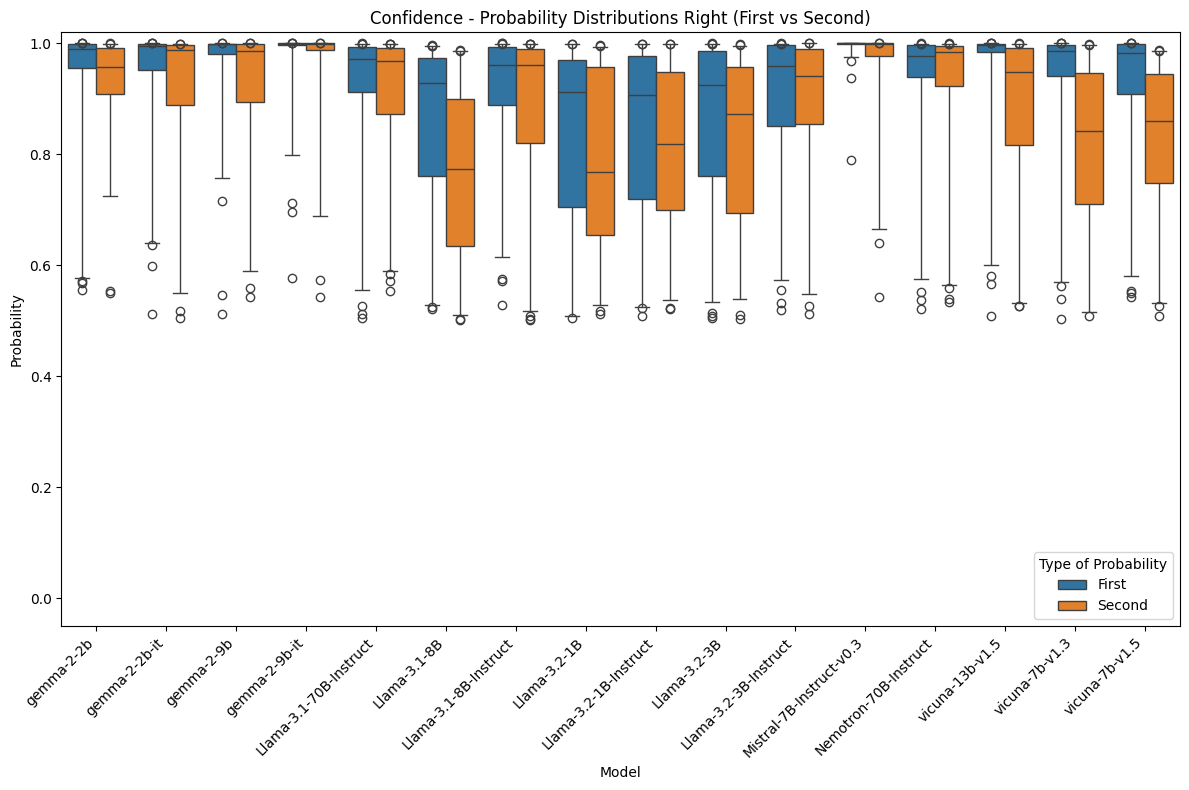

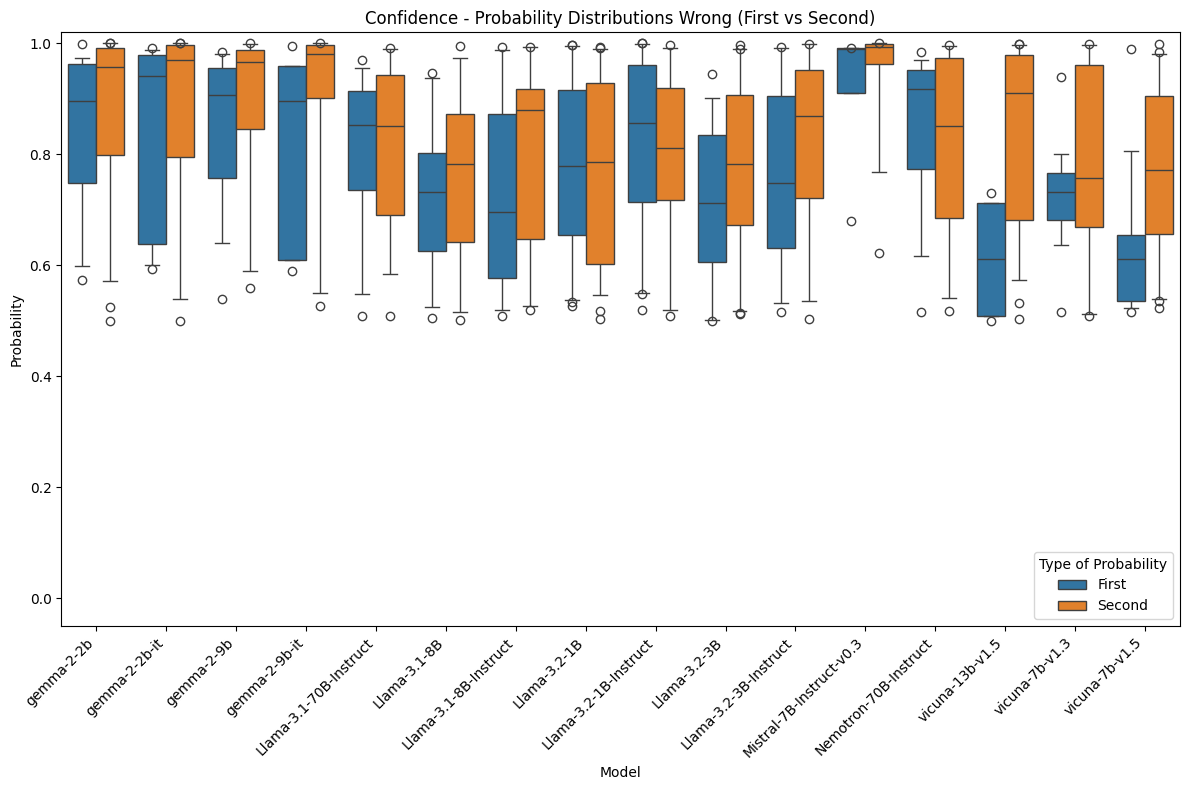

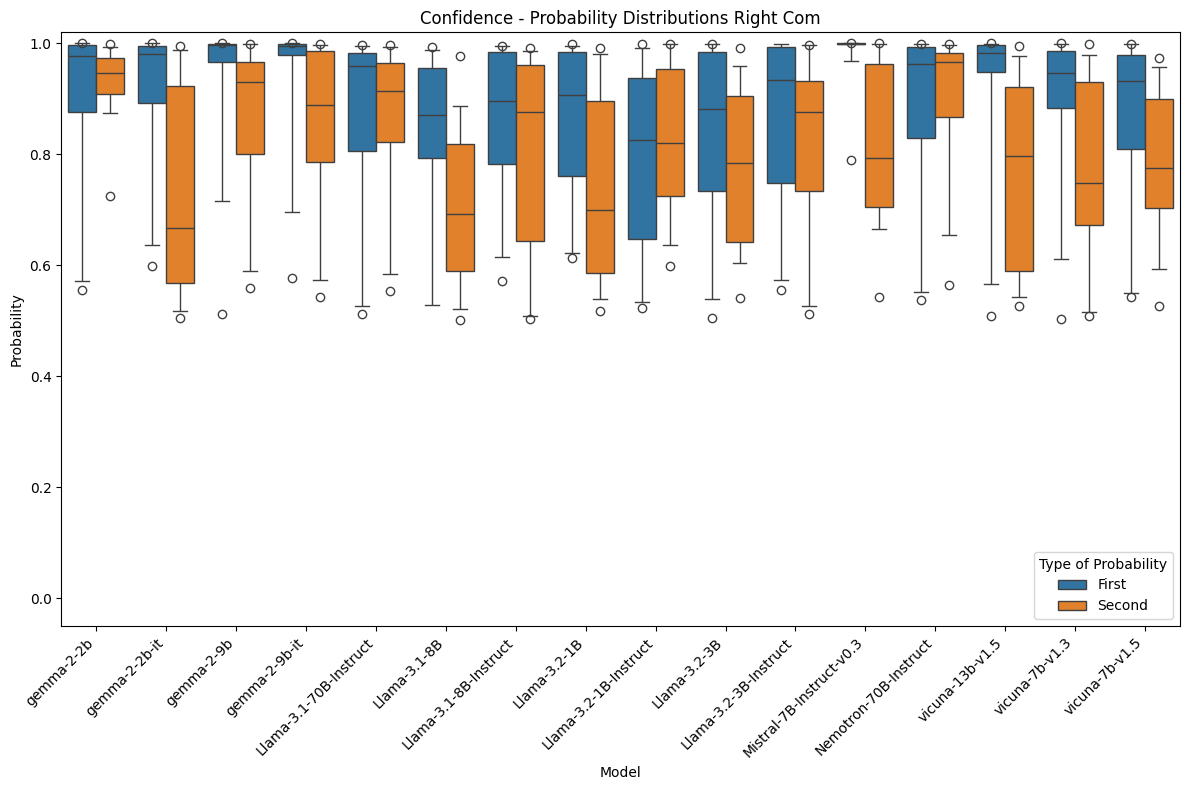

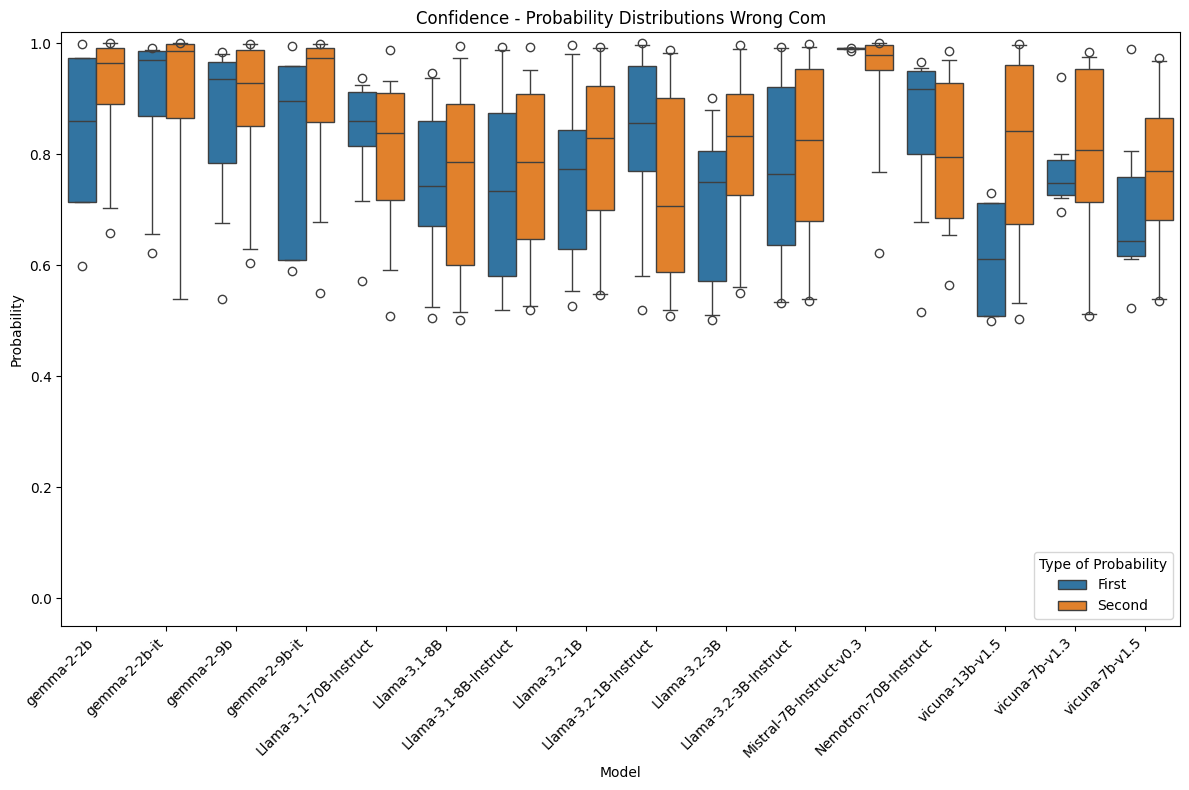

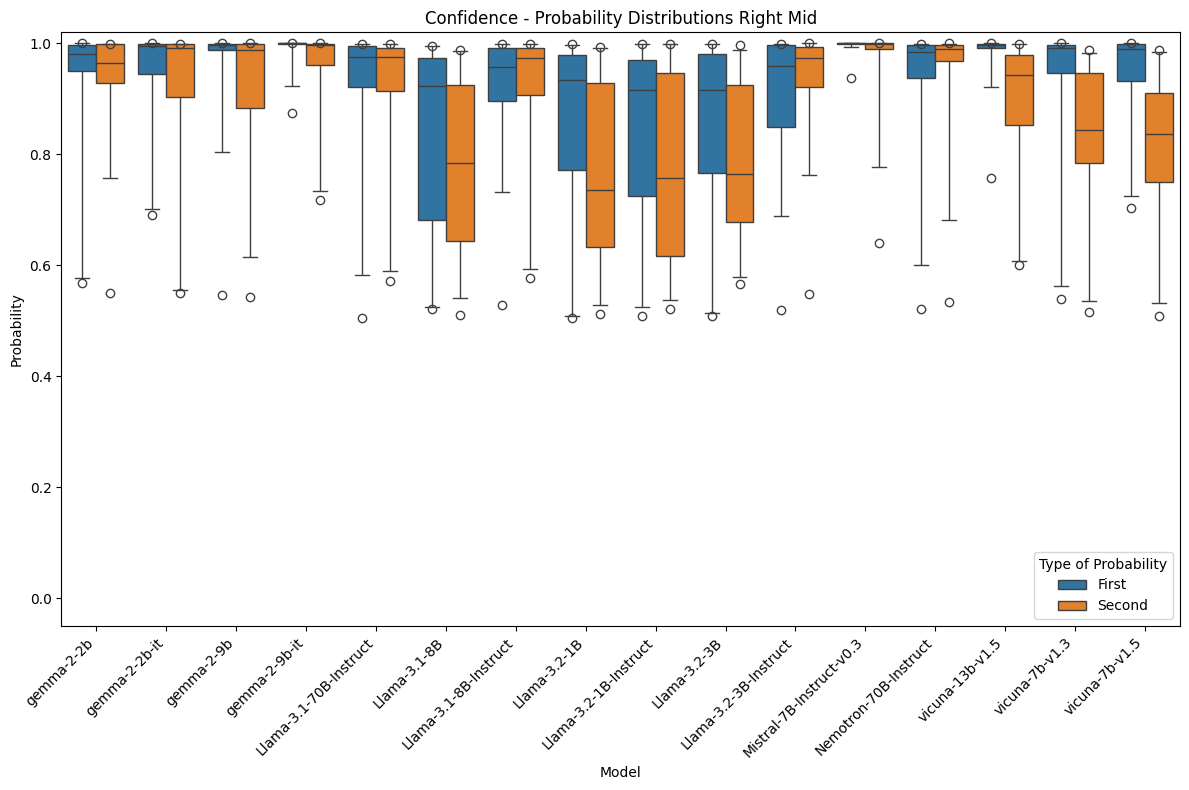

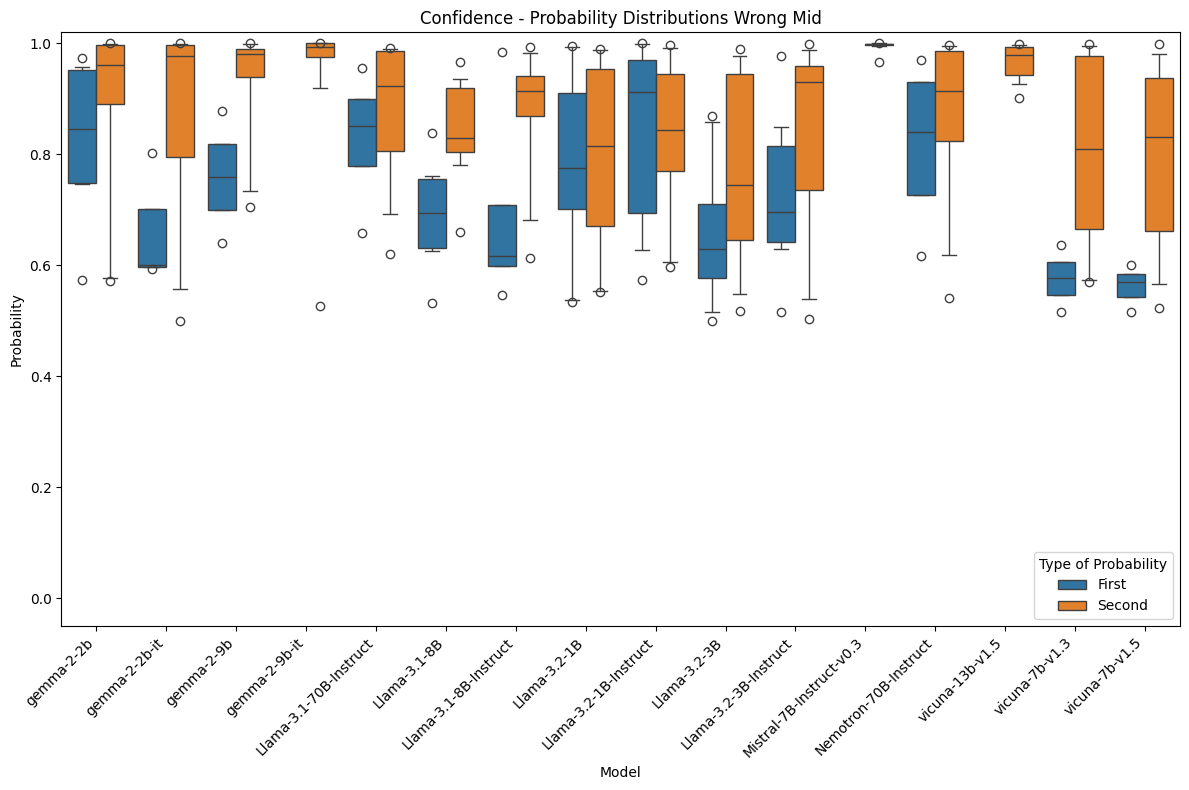

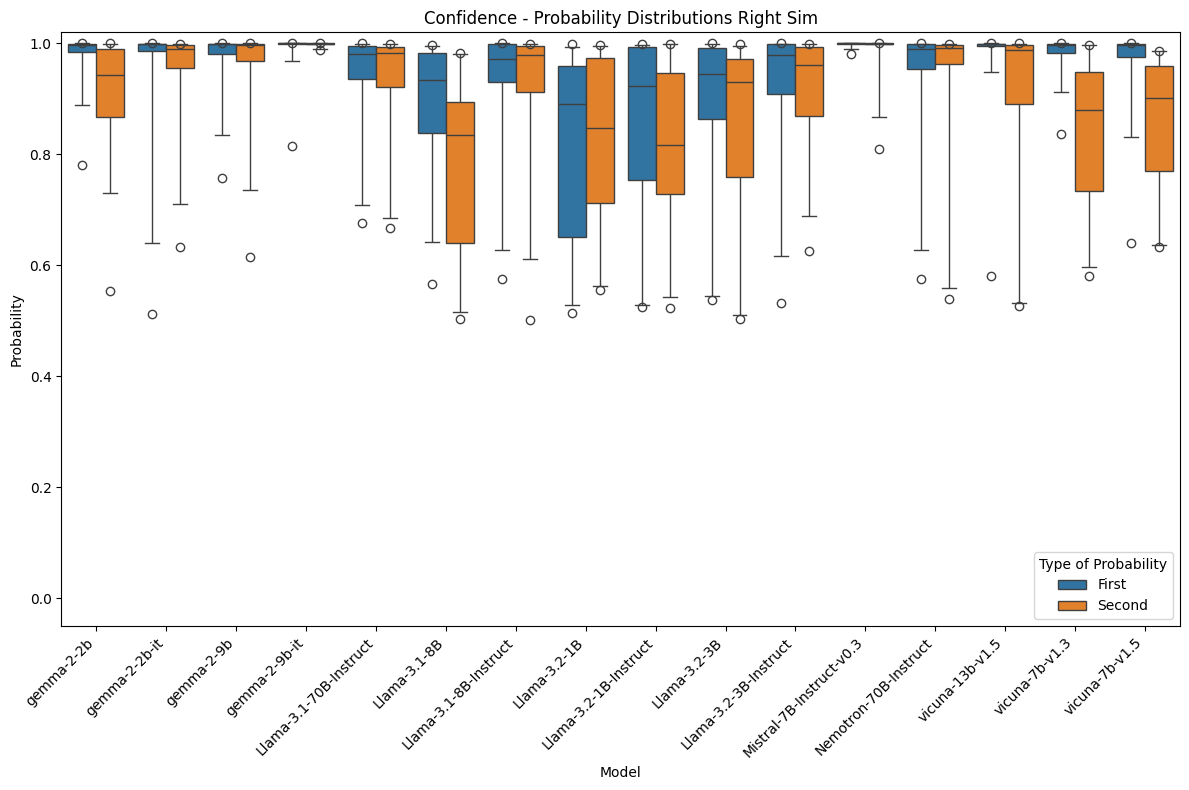

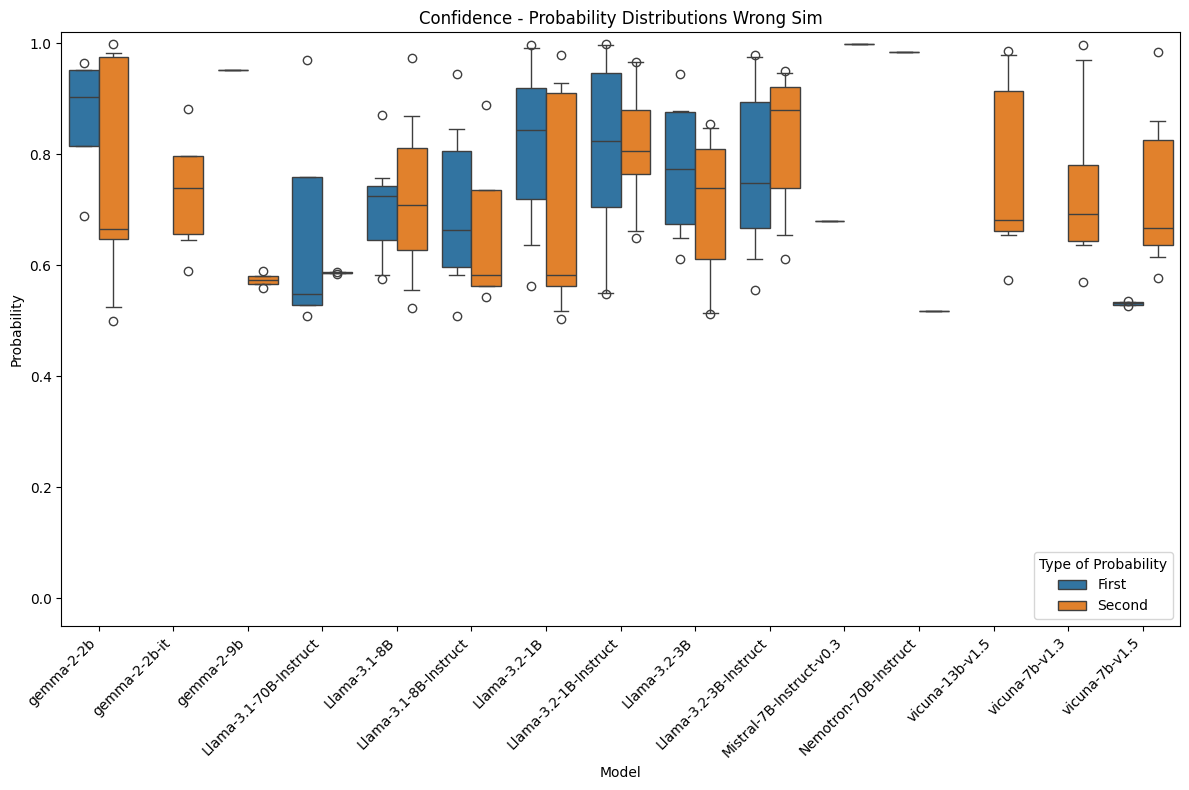

In [26]:
confidence_first_vs_second(all_data, isRight=True, wording=None)
confidence_first_vs_second(all_data, isRight=False, wording=None)
confidence_first_vs_second(all_data, isRight=True, wording="com")
confidence_first_vs_second(all_data, isRight=False, wording="com")
confidence_first_vs_second(all_data, isRight=True, wording="mid")
confidence_first_vs_second(all_data, isRight=False, wording="mid")
confidence_first_vs_second(all_data, isRight=True, wording="sim")
confidence_first_vs_second(all_data, isRight=False, wording="sim")

## Statistical tests

In [27]:
def print_to_screen_and_file(file_path, *args, **kwargs):
    # Print to the screen
    print(*args, **kwargs)

    # Open (or create) the file "CCC" in append mode
    with open(file_path + ".txt", "a") as file:
        print(*args, file=file, **kwargs)



In [28]:
from scipy.stats import mannwhitneyu

def perform_single_test(high, low, alternative, hypothesis, file_path, model_name, tableFormat=True):
  # high is the distribution with greater values
  if high.empty or low.empty:
    if tableFormat:
      print_to_screen_and_file(file_path, f"{model_name} & - & - & - \\\\")
    else:
      print_to_screen_and_file(file_path, "Not enough data to perform test")
      print_to_screen_and_file(file_path, "")
    return
  # Perform the Mann-Whitney U Test
  stat, p_value = mannwhitneyu(low, high, alternative=alternative)

  # Interpret the results
  alpha = 0.05
  isReject = (p_value < alpha)


  # Print the results
  if tableFormat:
    print_to_screen_and_file(file_path, f"{model_name} & {stat} & {p_value:.3e} & {isReject} \\\\")
  else:
    print_to_screen_and_file(file_path, f"U-statistic: {stat}")
    print_to_screen_and_file(file_path, f"P-value: {p_value}")
    if isReject:
      print_to_screen_and_file(file_path, f"Reject the null hypothesis: {hypothesis}.")
    else:
      print_to_screen_and_file(file_path, "Fail to reject the null hypothesis: No significant difference.")

    print_to_screen_and_file(file_path, "_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _")
    print_to_screen_and_file(file_path, "")

In [29]:
def stat_test_com_vs_non_com(df, file_path, tableFormat=True):

  models = df['model'].unique()


  for i, center_type in enumerate(["all", "first_center", "second_center"]):
    for right_wrong in ["right", "wrong"]:
      print_to_screen_and_file(file_path, f"{right_wrong} {center_type}")

      if right_wrong == "right":
        is_correct_prediction = True
        prob = "correct_probability"
        alternative = "less"
        hypothesis = "first center has significantly larger values"
      else:
        is_correct_prediction = False
        prob = "incorrect_probability"
        alternative = "greater"
        hypothesis = "first center has significantly lower values"


      for model in models:
          if not tableFormat:
            print_to_screen_and_file(file_path, f"Model name is: {model}")

          # Create com, non-com
          com = df[(df["wording"] =="com") & (df["is_correct_prediction"] == is_correct_prediction)]
          non_com = df[(~(df["wording"]=="com")) & (df["is_correct_prediction"] == is_correct_prediction)]

          if center_type != "all":
            com = com[com["center_type"] == center_type]
            non_com = non_com[non_com["center_type"] == center_type]
          # Filter by model
          com = com[com["model"] == model]
          non_com = non_com[non_com["model"] == model]

          com = com[prob]
          non_com = non_com[prob]

          perform_single_test(non_com, com, alternative, hypothesis, file_path, model, tableFormat)

      print_to_screen_and_file(file_path, "________________________________________________________________________")
      print_to_screen_and_file(file_path, "")

In [30]:
file_path = os.path.join(res_dir, f"com_vs_non_com_statistic_test")
stat_test_com_vs_non_com(all_data, file_path)

right all
gemma-2-2b & 3018.0 & 3.466e-02 & True \\
gemma-2-2b-it & 2622.5 & 3.119e-04 & True \\
gemma-2-9b & 4119.0 & 4.514e-02 & True \\
gemma-2-9b-it & 2016.0 & 5.974e-12 & True \\
Llama-3.1-70B-Instruct & 3921.5 & 1.158e-05 & True \\
Llama-3.1-8B & 3019.0 & 7.758e-02 & False \\
Llama-3.1-8B-Instruct & 2596.0 & 1.737e-06 & True \\
Llama-3.2-1B & 3020.5 & 3.302e-01 & False \\
Llama-3.2-1B-Instruct & 3272.0 & 3.042e-01 & False \\
Llama-3.2-3B & 3053.0 & 6.283e-02 & False \\
Llama-3.2-3B-Instruct & 2627.5 & 2.801e-04 & True \\
Mistral-7B-Instruct-v0.3 & 3460.0 & 6.365e-05 & True \\
Nemotron-70B-Instruct & 4086.5 & 1.773e-05 & True \\
vicuna-13b-v1.5 & 2999.5 & 9.798e-06 & True \\
vicuna-7b-v1.3 & 3821.0 & 1.715e-04 & True \\
vicuna-7b-v1.5 & 2664.5 & 6.557e-05 & True \\
________________________________________________________________________

wrong all
gemma-2-2b & 1220.0 & 4.358e-02 & True \\
gemma-2-2b-it & 752.0 & 3.596e-02 & True \\
gemma-2-9b & 344.0 & 7.159e-01 & False \\
gemma-2

In [31]:
def stat_test_first_vs_second(df, file_path, tableFormat=True):

  models = df['model'].unique()


  for i, wording in enumerate(["all", "com", "mid", "sim"]):
    for right_wrong in ["right", "wrong"]:
      print_to_screen_and_file(file_path, f"{right_wrong} {wording}")

      if right_wrong == "right":
        is_correct_prediction = True
        prob = "correct_probability"
        alternative = "less"
        hypothesis = "first center has significantly larger values"
      else:
        is_correct_prediction = False
        prob = "incorrect_probability"
        alternative = "greater"
        hypothesis = "first center has significantly lower values"


      for model in models:
          if not tableFormat:
            print_to_screen_and_file(file_path, f"Model name is: {model}")

          # Create first, second
          first = df[(df["center_type"] =="first_center") & (df["is_correct_prediction"] == is_correct_prediction)]
          second = df[(df["center_type"]=="second_center") & (df["is_correct_prediction"] == is_correct_prediction)]

          if wording != "all":
            first = first[first["wording"] == wording]
            second = second[second["wording"] == wording]
          first = first[first["model"] == model]
          second = second[second["model"] == model]

          first = first[prob]
          second = second[prob]

          perform_single_test(first, second, alternative, hypothesis, file_path, model, tableFormat)

      print_to_screen_and_file(file_path, "________________________________________________________________________")
      print_to_screen_and_file(file_path, "")



In [32]:
file_path = os.path.join(res_dir, f"first_vs_second_statistic_test")
stat_test_first_vs_second(all_data, file_path)

right all
gemma-2-2b & 2880.0 & 3.104e-04 & True \\
gemma-2-2b-it & 3917.5 & 1.359e-03 & True \\
gemma-2-9b & 4109.0 & 8.084e-06 & True \\
gemma-2-9b-it & 4534.0 & 9.042e-05 & True \\
Llama-3.1-70B-Instruct & 6722.5 & 1.897e-01 & False \\
Llama-3.1-8B & 3084.5 & 9.625e-06 & True \\
Llama-3.1-8B-Instruct & 5500.5 & 1.226e-01 & False \\
Llama-3.2-1B & 2886.0 & 6.574e-03 & True \\
Llama-3.2-1B-Instruct & 3644.0 & 1.241e-01 & False \\
Llama-3.2-3B & 3674.0 & 4.832e-03 & True \\
Llama-3.2-3B-Instruct & 4601.5 & 1.465e-01 & False \\
Mistral-7B-Instruct-v0.3 & 3342.5 & 2.719e-11 & True \\
Nemotron-70B-Instruct & 7379.0 & 5.033e-01 & False \\
vicuna-13b-v1.5 & 2654.0 & 1.043e-12 & True \\
vicuna-7b-v1.3 & 2269.0 & 1.551e-16 & True \\
vicuna-7b-v1.5 & 2188.5 & 7.176e-12 & True \\
________________________________________________________________________

wrong all
gemma-2-2b & 676.5 & 5.445e-02 & False \\
gemma-2-2b-it & 433.0 & 6.448e-02 & False \\
gemma-2-9b & 350.5 & 5.868e-02 & False \\
gemma

## Download results

In [33]:
import shutil
from google.colab import files

In [34]:
# Replace 'folder_path' with the path to the folder you want to download
folder_path = res_dir
zip_file_path = f'/content/results.zip'

# Zip the folder
shutil.make_archive(zip_file_path.replace('.zip', ''), 'zip', folder_path)

# Download the zip file
files.download(zip_file_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [35]:
shutil.rmtree(f"/{res_dir}")